# Titanic Survival Prediction
In this notebook I apply the random forest model to a Titantic dataset in order to predict the passengers who survive.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = 'data/'

In [4]:
!ls {PATH}

gender_submission.csv
test.csv
train.csv


## Explore Data

In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv')

In [6]:
def display_all(data): 
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(data)

In [7]:
display_all(df_raw.tail().T)

,886,887,888,889,890
PassengerId,887,888,889,890,891
Survived,0,1,0,1,0
Pclass,2,1,3,1,3
Name,"Montvila, Rev. Juozas","Graham, Miss. Margaret Edith","Johnston, Miss. Catherine Helen ""Carrie""","Behr, Mr. Karl Howell","Dooley, Mr. Patrick"
Sex,male,female,female,male,male
Age,27,19,NaN,26,32
SibSp,0,0,1,0,0
Parch,0,0,2,0,0
Ticket,211536,112053,W./C. 6607,111369,370376
Fare,13,30,23.45,30,7.75


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Leitch, Miss. Jessie Wills",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,1601,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


In [9]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

## Data Prep
Here we convert the categorical features from strings to categories.

In [10]:
train_cats(df_raw)

In [11]:
df_raw.Ticket.cat.categories

Index(['110152', '110413', '110465', '110564', '110813', '111240', '111320',
       '111361', '111369', '111426',
       ...
       'STON/O2. 3101290', 'SW/PP 751', 'W./C. 14258', 'W./C. 14263',
       'W./C. 6607', 'W./C. 6608', 'W./C. 6609', 'W.E.P. 5734', 'W/C 14208',
       'WE/P 5735'],
      dtype='object', length=681)

Save DataFrame to file since it is in usable state.

In [12]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/titanic_raw')

## Preprocessing from Feather
Can start here to prevent having to reload data from csv everytime.

In [13]:
df_raw = pd.read_feather('tmp/titanic_raw')

In [14]:
df, y, nas = proc_df(df_raw, y_fld='Survived')

Now we create a train, valid, and dev set for use in model iteration, before we train on the full dataset.

In [15]:
def split_data(df, y, n_val):
    val_idxs = df.index.isin(np.random.choice(len(df), size=n_val, replace=False))
    return df[~val_idxs].copy().reset_index(drop=True), y[~val_idxs].copy(), \
            df[val_idxs].copy().reset_index(drop=True), y[val_idxs].copy()

In [16]:
df_train, y_train, df_valid, y_valid = split_data(df, y, 200)

Here, we create a dev set in order to speed up our iteration. Once we have found a good model and hyperparameters, we will train on the entire training set.

In [17]:
_, _, df_train, y_train = split_data(df_train, y_train, 200)

## Create Model

In [18]:
def print_score(m):
    res = {'train_accuracy': m.score(df_train, y_train), 'valid_accuracy': m.score(df_valid, y_valid)}
    if hasattr(m, 'oob_score_'): res['oob_score'] = m.oob_score_
    return res

First, we try a baseline model using the default parameters.

In [46]:
m = RandomForestClassifier(n_jobs=-1)

In [47]:
%time m.fit(df_train, y_train)
print_score(m)

C:\Users\goofy\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 129 ms


{'train_accuracy': 0.995, 'valid_accuracy': 0.795}

Currently, we see the model is overfitting greatly on the training dataset.

### Varying Number of Trees
Now we explore how accuracy changes with the addition of more decision trees.

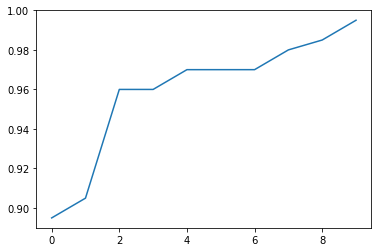

In [48]:
preds = np.stack([t.predict_proba(df_train) for t in m.estimators_])
plt.plot([metrics.accuracy_score(y_train, np.argmax(np.mean(preds[:i+1], axis=0), axis=1)) for i in range(len(m.estimators_))])

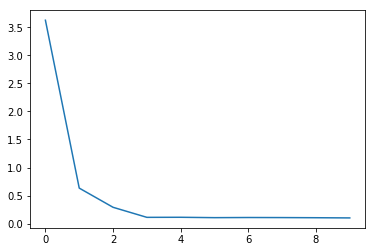

In [49]:
plt.plot([metrics.log_loss(y_train, np.mean(preds[:i+1], axis=0)) for i in range(len(m.estimators_))])

### Single Tree
Now we look at a single decision tree to explore what features are most important to our model.

In [50]:
m = RandomForestClassifier(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(df_train, y_train)
print_score(m)

{'train_accuracy': 1.0, 'valid_accuracy': 0.745}

As expected, when using a single decision tree without bootstraping, we achieve a training accuracy of 1.0. Thus, our model seems to be working properly because it is able to overfit. Now we will introduce regularization techniques in order to combat our overfitting.

In [51]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(df_train, y_train)
print_score(m)

{'train_accuracy': 0.815, 'valid_accuracy': 0.795}

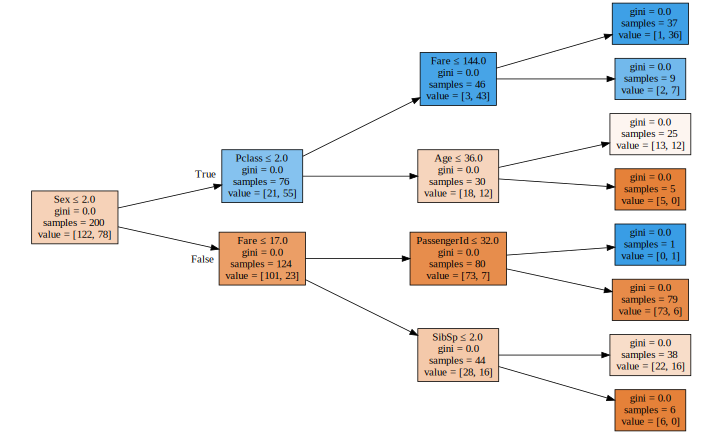

In [52]:
draw_tree(m.estimators_[0], df_train)

It looks like sex, ticket class, and whether the individual has any parents or children on the ship are the most important features. 